In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from datetime import datetime
import pytz
from matplotlib.dates import DateFormatter
matplotlib.rcParams['timezone'] = 'US/Eastern'

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/alex/nyt-2020-election-scraper/master/battleground-state-changes.csv")
(df.vote_differential
 .where(df.leading_candidate_name == "Biden", other=df.vote_differential * -1, inplace=True))

recount_threshold = (df.groupby("state")
               .apply(
                   lambda state_df: (
                       state_df["leading_candidate_votes"] + 
                       state_df["trailing_candidate_votes"] + 
                       state_df["votes_remaining"]
                   ).iloc[-1])) * 0.005

In [3]:
eastern = pytz.timezone('US/Eastern')
df.index = pd.to_datetime(df['timestamp'])
df.index = df.index.tz_localize(pytz.utc).tz_convert(eastern)
pa = df.loc[df["state"].str.startswith("Penn"), "vote_differential"]
ga = df.loc[df["state"].str.startswith("Georgia"), "vote_differential"]
az = df.loc[df["state"].str.startswith("Arizona"), "vote_differential"]
nv = df.loc[df["state"].str.startswith("Nevada"), "vote_differential"]

In [4]:
def deficit_plot(df, label="", ax=None, recount=None):
    if not ax:
        fig, ax = plt.subplots(1,1, figsize=(6,4))
    df.plot(ax=ax, label=label)
    ax.set_xlim(("2020-11-05", None))
    ax.set_ylim(
        min(min(df[df.index >= "2020-11-05"]), 0, (recount or 0)*-1) * 1.4, 
        max(max(df[df.index >= "2020-11-05"]), 0, recount or 0) * 1.4
    )
    if recount:
        ax.fill_between(ax.get_xlim(), [recount, recount], [-recount, -recount], alpha=0.1, label="recount")
    ax.set_ylabel("Biden Lead")
    ax.set_xlabel("Time (Eastern)")
    ax.get_figure().set_facecolor("white")
    date_form = DateFormatter("%m/%d %-I%p")
    ax.xaxis.set_major_formatter(date_form)
    ax.legend();
    ax.grid()


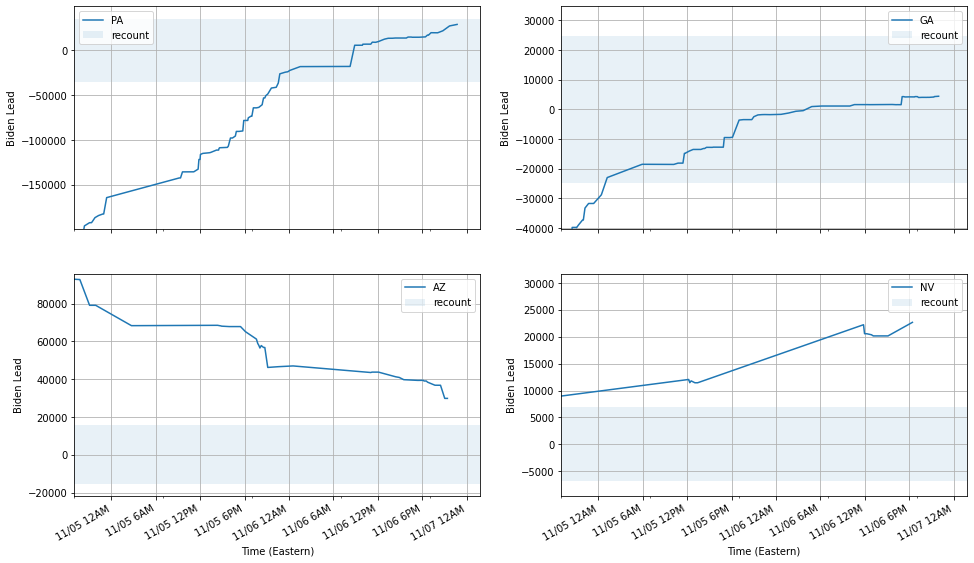

In [5]:
fig, axs = plt.subplots(2,2, figsize=(16,10), sharex=True)
deficit_plot(pa, "PA", axs.ravel()[0], recount=recount_threshold["Pennsylvania (EV: 20)"])
deficit_plot(ga, "GA", axs.ravel()[1], recount=recount_threshold["Georgia (EV: 16)"])
deficit_plot(az, "AZ", axs.ravel()[2], recount=recount_threshold["Arizona (EV: 11)"])
deficit_plot(nv, "NV", axs.ravel()[3], recount=recount_threshold["Nevada (EV: 6)"])
fig.savefig("plot1.png", bbox_inches="tight")

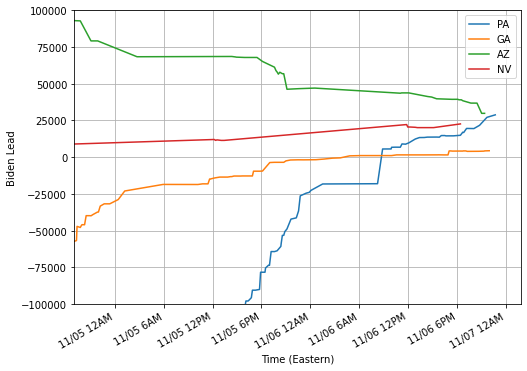

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
deficit_plot(pa, "PA", ax)
deficit_plot(ga, "GA", ax)
deficit_plot(az, "AZ", ax)
deficit_plot(nv, "NV", ax)
ax.set_ylim(-100000, 100000)
fig.savefig("plot2.png", bbox_inches="tight")